In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [14]:
#MLP code from makemore 1.0
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(42)
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator = g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator = g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True
print(sum(p.nelement() for p in parameters))

11897


In [15]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    #construct minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,),generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    #forward pass
    emb = C[Xb] #embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) #concatenate the vectors for the multiple characters that we're taking for the context
    hpreact = embcat @ W1 + b1 #hidden layer pre-activation
    h = torch.tanh(hpreact) #hidden layer
    logits = h @ W2 + b2 #output layer
    loss = F.cross_entropy(logits, Yb) 

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 1e-1
    for p in parameters:
        p.data += -lr * p.grad

    #track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())    

    break

      0/ 200000: 3.3047


(array([2369.,  165.,   91.,   64.,   51.,   44.,   36.,   35.,   27.,
          24.,   24.,   25.,   22.,   20.,   28.,   18.,   23.,   15.,
          17.,   21.,   21.,   18.,    9.,   16.,   21.,   22.,   21.,
          21.,   20.,   14.,    9.,   16.,   17.,   16.,   25.,   28.,
          17.,   16.,   19.,   25.,   27.,   28.,   31.,   26.,   42.,
          48.,   60.,   69.,  153., 2426.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <BarContainer object of 50 artists>)

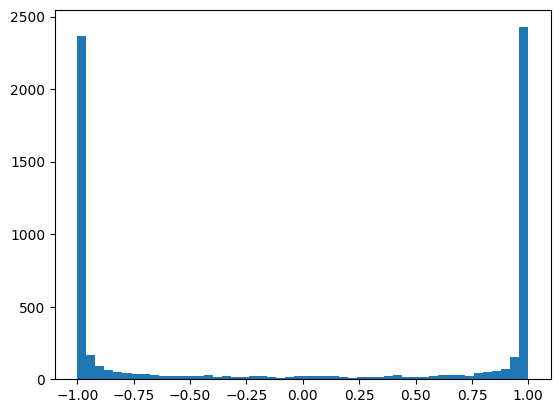

In [16]:
plt.hist(h.view(-1).tolist(), 50)

(array([  1.,   3.,   2.,   2.,   7.,   3.,  12.,   9.,  17.,  24.,  52.,
         74.,  91., 101., 127., 155., 214., 235., 292., 326., 325., 393.,
        409., 414., 356., 364., 407., 345., 333., 255., 194., 202., 164.,
        109.,  85.,  72.,  53.,  48.,  38.,  33.,  13.,  20.,   7.,   3.,
          7.,   1.,   1.,   0.,   1.,   1.]),
 array([-22.45796967, -21.51564533, -20.573321  , -19.63099667,
        -18.68867233, -17.746348  , -16.80402367, -15.86169933,
        -14.919375  , -13.97705067, -13.03472633, -12.092402  ,
        -11.15007767, -10.20775333,  -9.265429  ,  -8.32310467,
         -7.38078033,  -6.438456  ,  -5.49613167,  -4.55380733,
         -3.611483  ,  -2.66915867,  -1.72683434,  -0.78451   ,
          0.15781433,   1.10013866,   2.042463  ,   2.98478733,
          3.92711166,   4.869436  ,   5.81176033,   6.75408466,
          7.696409  ,   8.63873333,   9.58105766,  10.523382  ,
         11.46570633,  12.40803066,  13.350355  ,  14.29267933,
         15.235003

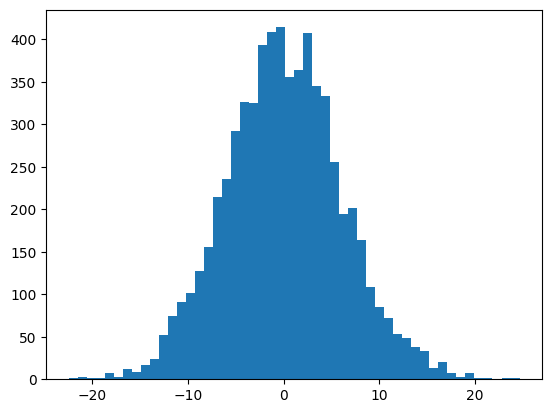

In [18]:
plt.hist(hpreact.view(-1).tolist(), 50)

Most of our tanh outputs are -1 or 1, which might be squashing our gradient passing through the tanh neuron

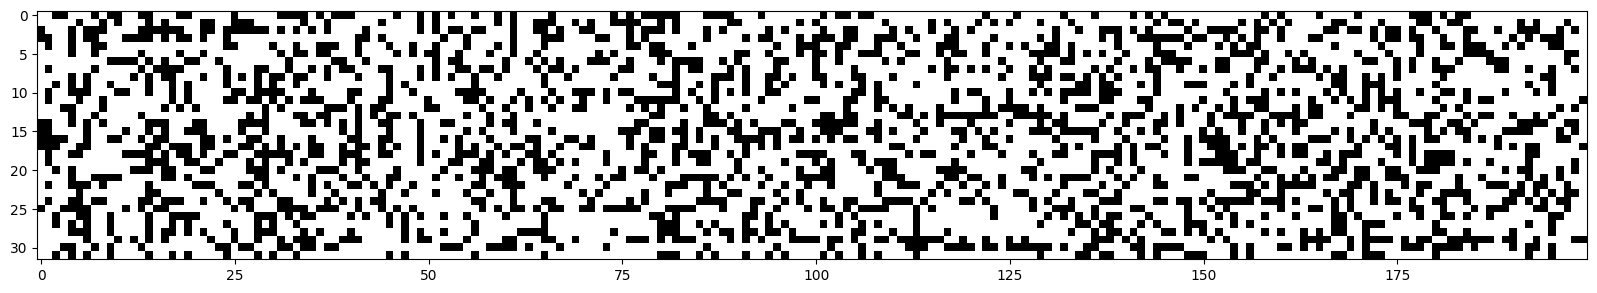

In [17]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap = 'gray', interpolation= 'nearest')

The backward gradient gets destroyed for all the neurons here which are white, but we don't have any dead neurons (completely white column)

In [33]:
#MLP code from makemore 1.0
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(42)
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator = g) * (5/3) / ((n_embd * block_size)**0.5) #kaiming normal initialisation
#b1 = torch.randn(n_hidden, generator=g) *0.01  batch normalisation makes this useless
W2 = torch.randn((n_hidden, vocab_size), generator = g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

batch_normalization_gain = torch.ones((1,n_hidden))
batch_normalization_bias = torch.zeros((1,n_hidden))
bnmean_running = torch.zeros((1,n_hidden))
bnstd_running = torch.ones((1,n_hidden))

parameters = [C, W1, W2, b2, batch_normalization_gain, batch_normalization_bias]
for p in parameters:
    p.requires_grad = True
print(sum(p.nelement() for p in parameters))

12297


In [31]:
hpreact.mean(0, keepdim=True).shape

torch.Size([1, 200])

In [32]:
hpreact.std(0, keepdim=True).shape

torch.Size([1, 200])

In [34]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    #construct minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,),generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    #forward pass
    emb = C[Xb] #embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) #concatenate the vectors for the multiple characters that we're taking for the context
    hpreact = embcat @ W1 #+ b1 #hidden layer pre-activation - batch normalisation makes the bias useless
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    #batch normalisation is usually used after layers that have multiplications that make the distribution not gaussian/normal. e.g., convolutional or linear layers
    hpreact = batch_normalization_gain *  (hpreact - bnmeani) / bnstdi + batch_normalization_bias
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstd_running

    h = torch.tanh(hpreact) #hidden layer
    logits = h @ W2 + b2 #output layer
    loss = F.cross_entropy(logits, Yb) 

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 1e-1
    for p in parameters:
        p.data += -lr * p.grad

    #track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())    

      0/ 200000: 3.3149
  10000/ 200000: 2.3311
  20000/ 200000: 2.4343
  30000/ 200000: 2.0402
  40000/ 200000: 2.1428
  50000/ 200000: 1.8935
  60000/ 200000: 2.1852
  70000/ 200000: 2.4852
  80000/ 200000: 2.2232
  90000/ 200000: 1.9615
 100000/ 200000: 2.0917
 110000/ 200000: 2.2423
 120000/ 200000: 2.1161
 130000/ 200000: 2.2129
 140000/ 200000: 2.0319
 150000/ 200000: 2.2720
 160000/ 200000: 2.3426
 170000/ 200000: 1.8352
 180000/ 200000: 2.6085
 190000/ 200000: 2.0985


In [37]:
#calibrate the batch norm at the end of training - we don't need to do this in a separate stage - the running mean and standard deviation above also work 
with torch.no_grad():
    emb = C[Xtr] #pass the training set through
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    #measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

(array([319., 244., 215., 174., 167., 151., 127., 130., 120., 134., 111.,
        103., 124., 111.,  81., 106.,  64.,  90.,  87.,  99.,  81.,  85.,
        103.,  76.,  83.,  82.,  81.,  77.,  83.,  90.,  83.,  75.,  80.,
        101., 108., 107., 115., 110., 118.,  86., 115., 129., 132., 150.,
        157., 151., 169., 234., 231., 351.]),
 array([-9.99571502e-01, -9.59583131e-01, -9.19594760e-01, -8.79606389e-01,
        -8.39618018e-01, -7.99629647e-01, -7.59641275e-01, -7.19652904e-01,
        -6.79664533e-01, -6.39676162e-01, -5.99687791e-01, -5.59699420e-01,
        -5.19711049e-01, -4.79722677e-01, -4.39734306e-01, -3.99745935e-01,
        -3.59757564e-01, -3.19769193e-01, -2.79780822e-01, -2.39792451e-01,
        -1.99804080e-01, -1.59815708e-01, -1.19827337e-01, -7.98389661e-02,
        -3.98505950e-02,  1.37776136e-04,  4.01261473e-02,  8.01145184e-02,
         1.20102890e-01,  1.60091261e-01,  2.00079632e-01,  2.40068003e-01,
         2.80056374e-01,  3.20044745e-01,  3.60033

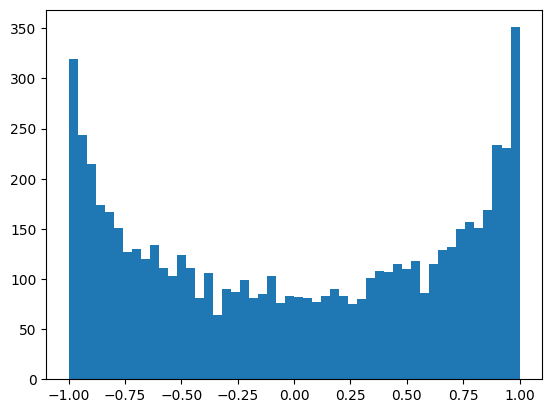

In [26]:
plt.hist(h.view(-1).tolist(), 50)

(array([  4.,   2.,   2.,   5.,   5.,   9.,  11.,  18.,  22.,  39.,  67.,
         86.,  76., 106., 165., 196., 195., 255., 285., 332., 378., 323.,
        388., 378., 352., 387., 373., 305., 310., 265., 195., 202., 164.,
        105.,  91.,  72.,  52.,  43.,  47.,  30.,  26.,  11.,   5.,   6.,
          6.,   2.,   2.,   0.,   0.,   2.]),
 array([-4.224051  , -4.04478444, -3.86551788, -3.68625133, -3.50698477,
        -3.32771821, -3.14845165, -2.96918509, -2.78991854, -2.61065198,
        -2.43138542, -2.25211886, -2.07285231, -1.89358575, -1.71431919,
        -1.53505263, -1.35578608, -1.17651952, -0.99725296, -0.8179864 ,
        -0.63871984, -0.45945329, -0.28018673, -0.10092017,  0.07834639,
         0.25761294,  0.4368795 ,  0.61614606,  0.79541262,  0.97467917,
         1.15394573,  1.33321229,  1.51247885,  1.69174541,  1.87101196,
         2.05027852,  2.22954508,  2.40881164,  2.58807819,  2.76734475,
         2.94661131,  3.12587787,  3.30514442,  3.48441098,  3.66367754,
 

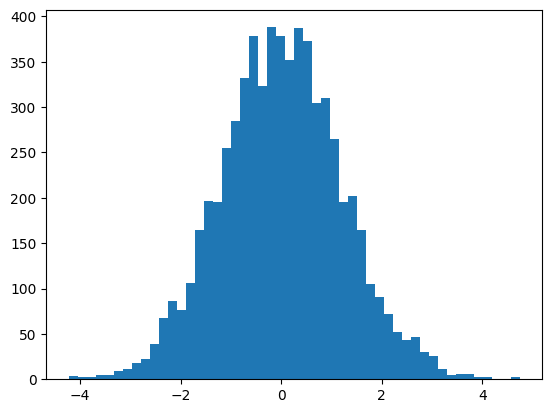

In [27]:
plt.hist(hpreact.view(-1).tolist(), 50)

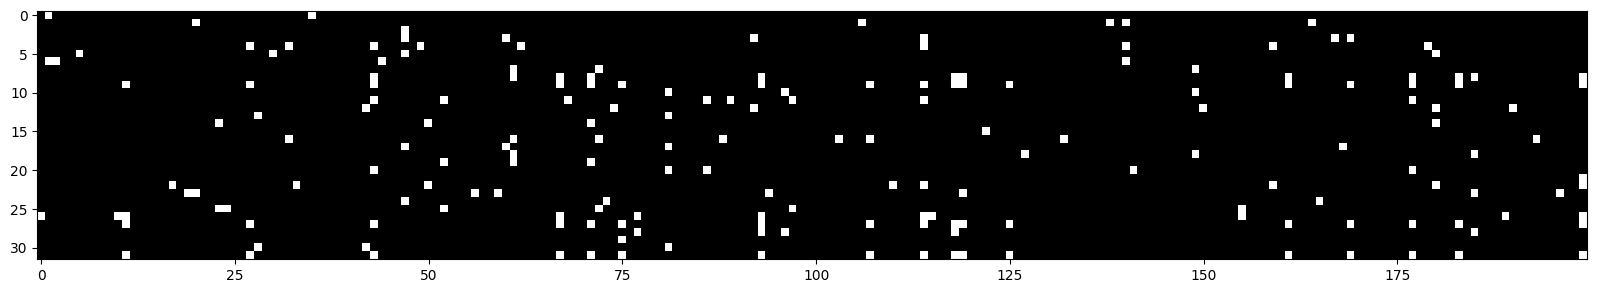

In [28]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap = 'gray', interpolation= 'nearest')

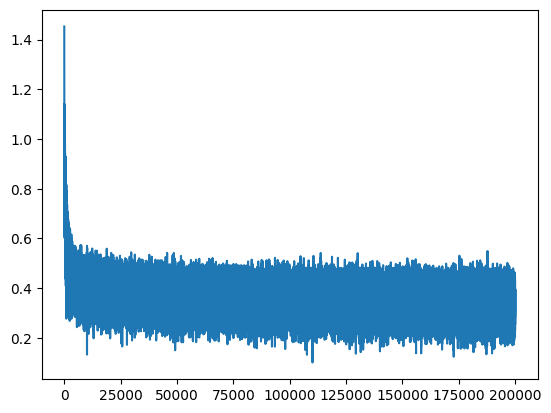

In [11]:
plt.plot(lossi)

In [38]:
@torch.no_grad
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]

    emb = C[x] #(N, block_size, n_embed)
    embcat = emb.view(emb.shape[0], -1) #concat into (N, block_size * n_embed)
    hpreact = embcat @ W1 + b1
    hpreact = batch_normalization_gain *  (hpreact - bnmean) / bnstd + batch_normalization_bias
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (n_hidden, vocal_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.1265270709991455
val 2.174251079559326


In [36]:
#sample from the model
g = torch.Generator().manual_seed(42)
for _ in range(10):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])] #(1,block_size,d)
        h = torch.tanh(emb.view(1,-1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim = 1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

trevernvt.
smarriquedmitubralikharlenak.
mahzim.
lnan.
jaysleeghakzi.
dem.
mabdurra.
dazlk.
miqueyjabduvellisabralchartancephassiquetch.
relyth.


### Torch-ifying the code

In [41]:
class Linear:
    def __init__(self, fan_in, fan_out, bias = True):
        self.weights = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5 #kaiming normal init
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weights
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weights] + ([] if self.bias is None else [self.bias])    
    
class BatchNorm1d:
    def __init__(self, dim, eps = 1e-5, momentum = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        #parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        #buffers (trained with a running momentum update)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        #forward pass
        if self.training:
            xmean = x.mean(0, keepdim = True) #batch mean
            xvar = x.var(0, keepdim = True) #batch std
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) #normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        #update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__(self,x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

In [42]:
n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(42)

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
]

with torch.no_grad():
    #last layer: make less confident
    layers[-1].weights *= 0.1
    #all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weights *= 5/3 #gain for tanh

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

46497


In [ ]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    #construct minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,),generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    #forward pass
    emb = C[Xb] #embed the characters into vectors
    x = emb.view(emb.shape[0], -1) #concatenate the vectors for the multiple characters that we're taking for the context
    for layer in layers:    #all the previous work is done by the layers now
        x = layer(x)
    loss = F.cross_entropy(x, Yb) 

    #backward pass
    for layer in layers:
        layer.out.retain_grad() #AFTER_DEB: take out retain_grad
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 1e-1 if i < 100000 else 1e-2
    for p in parameters:
        p.data += -lr * p.grad

    #track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())    

    break #AFTER_DEBUG: take out the break